# Интеллектуальный анализ данных – весна 2024
# Домашнее задание 6: классификация текстов

Правила:



*   Домашнее задание оценивается в 10 баллов.
*   Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.
*  Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.
*  Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.
*  Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.

В этом домашнем задании вам предстоит построить классификатор текстов.

Будем предсказывать эмоциональную окраску твиттов о коронавирусе.



In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [4]:
!wget https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv
df = pd.read_csv('/content/tweets_coronavirus.csv', encoding='latin-1')
df.sample(4)

--2024-05-13 14:39:58--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw06_texts/tweets_coronavirus.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8829280 (8.4M) [text/plain]
Saving to: ‘tweets_coronavirus.csv’

tweets_coronavirus. 100%[===================>]   8.42M  --.-KB/s    in 0.09s   

2024-05-13 14:39:58 (96.6 MB/s) - ‘tweets_coronavirus.csv’ saved [8829280/8829280]



,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
5435,10401,55353,"Kansas City, MO",19-03-2020,What information about do you want to see Supe...,Positive
7809,13290,58242,"Maharashtra, India",20-03-2020,I wanted to take a minute to send a special th...,Positive
33148,44581,89533,"Madison, WI",13-04-2020,"""As food banks struggle to keep up with dramat...",Negative
18948,26868,71820,NaN,25-03-2020,This should terrify anyone living in #Vancouve...,Extremely Negative


Для каждого твитта указано:


*   UserName - имя пользователя, заменено на целое число для анонимности
*   ScreenName - отображающееся имя пользователя, заменено на целое число для анонимности
*   Location - местоположение
*   TweetAt - дата создания твитта
*   OriginalTweet - текст твитта
*   Sentiment - эмоциональная окраска твитта (целевая переменная)



## Задание 1 Подготовка (0.5 балла)

Целевая переменная находится в колонке `Sentiment`.  Преобразуйте ее таким образом, чтобы она стала бинарной: 1 - если у твитта положительная эмоциональная окраска и 0 - если отрицательная.

In [5]:
df["Sentiment"].value_counts()

Sentiment
Positive              11422
Negative               9917
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [6]:
# Замена эмоциональной окраски на бинарные значения
sentiment_mapping = {
    'Positive': 1,
    'Extremely Positive': 1,
    'Negative': 0,
    'Extremely Negative': 0
}

df['Sentiment'] = df['Sentiment'].map(sentiment_mapping)


Сбалансированы ли классы?

In [7]:
class_counts = df['Sentiment'].value_counts()
print(class_counts)


Sentiment
1    18046
0    15398
Name: count, dtype: int64


In [8]:
positive_ratio = class_counts[1] / len(df)
negative_ratio = class_counts[0] / len(df)

print("Доля положительных твиттов:", positive_ratio)
print("Доля отрицательных твиттов:", negative_ratio)


Доля положительных твиттов: 0.5395885659610095
Доля отрицательных твиттов: 0.46041143403899054


**Ответ:** классы сбалансированы

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их строкой 'Unknown'.

In [9]:
missing_values = df.isnull().sum()
print(missing_values)


UserName            0
ScreenName          0
Location         7049
TweetAt             0
OriginalTweet       0
Sentiment           0
dtype: int64


In [10]:
df.fillna('Unknown', inplace=True)


In [11]:
missing_values = df.isnull().sum()
print(missing_values)


UserName         0
ScreenName       0
Location         0
TweetAt          0
OriginalTweet    0
Sentiment        0
dtype: int64


Разделите данные на обучающие и тестовые в соотношении 7 : 3 и `random_state=0`

In [12]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=0)

## Задание 2 Токенизация (3 балла)

Постройте словарь на основе обучающей выборки и посчитайте количество встреч каждого токена с использованием самой простой токенизации - деления текстов по пробельным символам и приведение токенов в нижний регистр

In [13]:
token_counts = {}
for tweet in train['OriginalTweet']:
    tokens = tweet.lower().split()
    for token in tokens:
        if token in token_counts:
            token_counts[token] += 1
        else:
            token_counts[token] = 1


Какой размер словаря получился?

In [14]:
print("Размер словаря:", len(token_counts))


Размер словаря: 79755


Выведите 10 самых популярных токенов с количеством встреч каждого из них. Объясните, почему именно эти токены в топе

In [15]:
# Сортировка словаря по убыванию частот и вывод топ-10 токенов
top_tokens = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Вывод топ-10 токенов
for token, count in top_tokens:
    print(f"Токен: {token}, Количество: {count}")


Токен: the, Количество: 26815
Токен: to, Количество: 23373
Токен: and, Количество: 14684
Токен: of, Количество: 13012
Токен: a, Количество: 11737
Токен: in, Количество: 11198
Токен: for, Количество: 8566
Токен: #coronavirus, Количество: 8223
Токен: is, Количество: 7383
Токен: are, Количество: 7050


**Ответ:** топ состоит из предлогов и артиклей, так как они наиболее часто встречаются в речи, также в топе есть ключевое слово (коронавирус), потому что мы анализируем твиты по этому тегу


Удалите стоп-слова из словаря и выведите новый топ-10 токенов (и количество встреч) по популярности.  Что можно сказать  о нем?

In [16]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

token_counts_filtered = {token: count for token, count in token_counts.items() if token not in stop_words}

top_tokens_filtered = sorted(token_counts_filtered.items(), key=lambda x: x[1], reverse=True)[:10]

for token, count in top_tokens_filtered:
    print(f"Токен: {token}, Количество: {count}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Токен: #coronavirus, Количество: 8223
Токен: prices, Количество: 3891
Токен: food, Количество: 3820
Токен: grocery, Количество: 3469
Токен: supermarket, Количество: 3288
Токен: people, Количество: 3175
Токен: covid-19, Количество: 3173
Токен: store, Количество: 3155
Токен: #covid19, Количество: 2471
Токен: &amp;, Количество: 2314


**Ответ:**  В этом топе уже встречаюсь слова, которые больше всего связаны с ключевой темой

Также выведите 20 самых непопулярных слов (если самых непопулярных слов больше выведите любые 20 из них) Почему эти токены непопулярны, требуется ли как-то дополнительно работать с ними?

In [17]:
bottom_tokens = sorted(token_counts.items(), key=lambda x: x[1])[:20]
for token, count in bottom_tokens:
    print(f"Токен: {token}, Количество: {count}")


Токен: https://t.co/1m881cwfuv, Количество: 1
Токен: happy.., Количество: 1
Токен: https://t.co/z0intks34x, Количество: 1
Токен: mnuchinãâs, Количество: 1
Токен: brink., Количество: 1
Токен: https://t.co/jmobv8z0u0, Количество: 1
Токен: university's, Количество: 1
Токен: teaching.), Количество: 1
Токен: @catholicpres, Количество: 1
Токен: @catholicuniv, Количество: 1
Токен: https://t.co/evqby035wf, Количество: 1
Токен: https://t.co/riqrhxxeim, Количество: 1
Токен: @@ballardspahrll, Количество: 1
Токен: #aca, Количество: 1
Токен: easier...take, Количество: 1
Токен: ãânecessaryãâ, Количество: 1
Токен: https://t.co/0fmsmlgepm, Количество: 1
Токен: husted:, Количество: 1
Токен: irishman, Количество: 1
Токен: #happystpatricksday!, Количество: 1


**Ответ:** # как мы видим, это либо отметки друзей либо ссылки, либо просто странное написание слов, они для нас бессмыслены



Теперь воспользуемся токенайзером получше - TweetTokenizer из библиотеки nltk. Примените его и посмотрите на топ-10 популярных слов. Чем он отличается от топа, который получался раньше? Почему?

In [18]:
from nltk.tokenize import TweetTokenizer

tokenizer = TweetTokenizer()

token_counts_tweet = {}
for tweet in train['OriginalTweet']:
    tokens = tokenizer.tokenize(tweet.lower())
    for token in tokens:
        if token in token_counts_tweet:
            token_counts_tweet[token] += 1
        else:
            token_counts_tweet[token] = 1

top_tokens_tweet = sorted(token_counts_tweet.items(), key=lambda x: x[1], reverse=True)[:10]

for token, count in top_tokens_tweet:
    print(f"Токен: {token}, Количество: {count}")


Токен: the, Количество: 26993
Токен: ., Количество: 24118
Токен: to, Количество: 23478
Токен: ,, Количество: 17571
Токен: and, Количество: 14825
Токен: of, Количество: 13044
Токен: a, Количество: 11891
Токен: in, Количество: 11348
Токен: ?, Количество: 9524
Токен: #coronavirus, Количество: 8808


**Ответ:** топ отличается, потому что также учитываются знаки препинания, которые определенно будут в топе

Удалите из словаря стоп-слова и пунктуацию, посмотрите на новый топ-10 слов с количеством встреч, есть ли теперь в нем что-то не похожее на слова?

In [19]:
from nltk.corpus import stopwords
from string import punctuation

stop_words = set(stopwords.words('english'))
token_counts_filtered_tweet = {token: count for token, count in token_counts_tweet.items() if token not in stop_words and token not in punctuation}
top_tokens_filtered_tweet = sorted(token_counts_filtered_tweet.items(), key=lambda x: x[1], reverse=True)[:10]
for token, count in top_tokens_filtered_tweet:
    print(f"Слово: {token}, Количество: {count}")


Слово: #coronavirus, Количество: 8808
Слово: â, Количество: 7415
Слово: , Количество: 7311
Слово: 19, Количество: 7167
Слово: covid, Количество: 6253
Слово: prices, Количество: 4601
Слово: , Количество: 4372
Слово: food, Количество: 4367
Слово: store, Количество: 3877
Слово: supermarket, Количество: 3805


**Ответ:** часть топа нормальные слова, другая часть просто символа, которые надо бы удалить

Удалите из словаря токены из одного символа, с позицией в таблице Unicode 128 и более (`ord(x) >= 128`)

Выведите топ-10 самых популярных и топ-20 непопулярных слов. Чем полученные топы отличаются от итоговых топов, полученных при использовании токенизации по пробелам? Что теперь лучше, а что хуже?

In [20]:

token_counts_filtered_tweet = {token: count for token, count in token_counts_filtered_tweet.items() if len(token) > 1 or ord(token) < 128}
sorted_filtered_tokens = sorted(token_counts_filtered_tweet.items(), key=lambda x: x[1], reverse=True)

print("Топ-10 самых популярных слов:")
for token, count in sorted_filtered_tokens[:10]:
    print(f"Слово: {token}, Количество: {count}")

print("\nТоп-20 самых непопулярных слов:")
for token, count in sorted_filtered_tokens[-20:]:
    print(f"Слово: {token}, Количество: {count}")


Топ-10 самых популярных слов:
Слово: #coronavirus, Количество: 8808
Слово: 19, Количество: 7167
Слово: covid, Количество: 6253
Слово: prices, Количество: 4601
Слово: food, Количество: 4367
Слово: store, Количество: 3877
Слово: supermarket, Количество: 3805
Слово: grocery, Количество: 3523
Слово: people, Количество: 3463
Слово: #covid19, Количество: 2589

Топ-20 самых непопулярных слов:
Слово: https://t.co/lw1r0rm7xs, Количество: 1
Слово: https://t.co/5cbliqzx7l, Количество: 1
Слово: now.when, Количество: 1
Слово: milion, Количество: 1
Слово: skellig, Количество: 1
Слово: @skelligsix18, Количество: 1
Слово: #skelligcoast2kms, Количество: 1
Слово: #southkerry, Количество: 1
Слово: https://t.co/zjcl195vqs, Количество: 1
Слово: @srinivasiyc, Количество: 1
Слово: https://t.co/iaek4fwsgz, Количество: 1
Слово: premiership, Количество: 1
Слово: non-playing, Количество: 1
Слово: subsidise, Количество: 1
Слово: playersã, Количество: 1
Слово: renewing, Количество: 1
Слово: flew, Количество: 1
Сло

**Ответ:** топ популярных слов практически такой же, а вот топ непопулярных слов разный, но в данном случае, тут более осмысленные слова/хештеги/отметки друзей

Выведите топ-10 популярных хештегов с количеством встреч. Что можно сказать о них?

In [22]:
import re

# Паттерн для извлечения хештегов
hashtag_pattern = re.compile(r'#\w+')

# Извлечение хештегов и подсчет их частот
hashtag_counts = {}
for tweet in train['OriginalTweet']:
    hashtags = hashtag_pattern.findall(tweet.lower())
    for hashtag in hashtags:
        if hashtag in hashtag_counts:
            hashtag_counts[hashtag] += 1
        else:
            hashtag_counts[hashtag] = 1

top_hashtags = sorted(hashtag_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print("Топ-10 популярных хештегов:")
for hashtag, count in top_hashtags:
    print(f"Хештег: {hashtag}, Количество: {count}")


Топ-10 популярных хештегов:
Хештег: #coronavirus, Количество: 8835
Хештег: #covid19, Количество: 2593
Хештег: #covid_19, Количество: 1735
Хештег: #covid2019, Количество: 946
Хештег: #covid, Количество: 863
Хештег: #toiletpaper, Количество: 744
Хештег: #socialdistancing, Количество: 465
Хештег: #coronacrisis, Количество: 448
Хештег: #pandemic, Количество: 257
Хештег: #coronaviruspandemic, Количество: 249


**Ответ:** хештеги отражают тематику и контекст обсуждаемых в твиттах событий эпохи коронавируса

То же самое проделайте для ссылок на сайт https://t.co Сравнима ли популярность ссылок с популярностью хештегов? Будет ли информация о ссылке на конкретную страницу полезна?

In [23]:
import re

# Паттерн для извлечения ссылок на сайт https://t.co
url_pattern = re.compile(r'https://t\.co/\w+')

# Извлечение ссылок и подсчет их частот
url_counts = {}
for tweet in train['OriginalTweet']:
    urls = url_pattern.findall(tweet.lower())
    for url in urls:
        if url in url_counts:
            url_counts[url] += 1
        else:
            url_counts[url] = 1

top_urls = sorted(url_counts.items(), key=lambda x: x[1], reverse=True)[:10]

print("Топ-10 популярных ссылок на сайт https://t.co:")
for url, count in top_urls:
    print(f"Ссылка: {url}, Количество: {count}")


Топ-10 популярных ссылок на сайт https://t.co:
Ссылка: https://t.co/oxa7swtond, Количество: 5
Ссылка: https://t.co/gp3eusapl8, Количество: 4
Ссылка: https://t.co/deftrui1pfã, Количество: 3
Ссылка: https://t.co/wrlhyzizaa, Количество: 3
Ссылка: https://t.co/kuwipf1kqw, Количество: 3
Ссылка: https://t.co/zjnrx6dkkn, Количество: 3
Ссылка: https://t.co/3gbbdpdjat, Количество: 3
Ссылка: https://t.co/e2znxajpre, Количество: 3
Ссылка: https://t.co/catkegayoy, Количество: 3
Ссылка: https://t.co/g63rp042ho, Количество: 3


**Ответ:** не сравнима, ссылки нам бесполезны

Используем опыт предыдущих экспериментов и напишем собственный токенайзер, улучшив TweetTokenizer. Функция tokenize должна:



*   Привести текст в нижний регистр
*   Применить TweetTokenizer для изначального выделения токенов
*   Удалить стоп-слова, пунктуацию, токены из одного символа, с позицией в таблице Unicode 128 и более и ссылки на t.co



In [38]:
def custom_tokenizer(text):
    text = text.lower()
    tk = TweetTokenizer()
    tokens = tk.tokenize(text)
    tokens = [token for token in tokens if not (
        len(token) == 1 and ord(token) >= 128 or  # Удаление токенов из одного символа с позицией в таблице Unicode 128 и более
        token in punctuation or  # Удаление пунктуации
        token.startswith("https://t.co/") or  # Удаление ссылок на t.co
        token in stopwords.words('english')  # Удаление стоп-слов
    )]

    return tokens


In [39]:
custom_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext')

['sample', 'text', '@sample_text', '#sampletext']

## Задание 3 Векторизация текстов (2 балла)

Обучите CountVectorizer с использованием custom_tokenizer в качестве токенайзера. Как размер полученного словаря соотносится с размером изначального словаря из начала задания 2?

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(tokenizer=custom_tokenizer)
cv.fit(train['OriginalTweet'])

print(len(cv.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


45308


**Ответ:** словарь практически в 2 раза меньше

Посмотрим на какой-нибудь конкретный твитт:

In [44]:
ind = 9023
train.iloc[ind]['OriginalTweet'], train.iloc[ind]['Sentiment']

('Nice one @SkyNews lets not panic but show ppl in france queueing for food!!! #CoronavirusOutbreak #COVID2019 brainless!! Ffs',
 0)

Автор твитта не доволен ситуацией с едой во Франции и текст имеет резко негативную окраску.

Примените обученный CountVectorizer для векторизации данного текста, и попытайтесь определить самый важный токен и самый неважный токен (токен, компонента которого в векторе максимальна/минимальна, без учета 0). Хорошо ли они определились, почему?

In [45]:
# Выбор конкретного твитта
ind = 9023
text = train.iloc[ind]['OriginalTweet']

text_vector = cv.transform([text])
tokens = cv.get_feature_names_out()
token_counts = {token: text_vector[0, idx] for idx, token in enumerate(tokens) if text_vector[0, idx] > 0}
for token, count in token_counts.items():
    print(f"Токен: {token}, Количество: {count}")


Токен: #coronavirusoutbreak, Количество: 1
Токен: #covid2019, Количество: 1
Токен: @skynews, Количество: 1
Токен: brainless, Количество: 1
Токен: ffs, Количество: 1
Токен: food, Количество: 1
Токен: france, Количество: 1
Токен: lets, Количество: 1
Токен: nice, Количество: 1
Токен: one, Количество: 1
Токен: panic, Количество: 1
Токен: ppl, Количество: 1
Токен: queueing, Количество: 1
Токен: show, Количество: 1


**Ответ:** все токены встречаюст по одному разу, из этого мы не можем сделать никакой вывод

Теперь примените TfidfVectorizer и  определите самый важный/неважный токены. Хорошо ли определились, почему?

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=custom_tokenizer)

text_vector_tfidf = tfidf.fit_transform(train['OriginalTweet'])
text_vector_tfidf_specific = tfidf.transform([text])


tokens_tfidf = tfidf.get_feature_names_out()
token_weights = {tokens_tfidf[idx]: text_vector_tfidf_specific[0, idx] for idx in range(len(tokens_tfidf)) if text_vector_tfidf_specific[0, idx] > 0}
for token, weight in token_weights.items():
    print(f"Токен: {token}, Вес: {weight}")


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Токен: #coronavirusoutbreak, Вес: 0.22584265007428544
Токен: #covid2019, Вес: 0.16825192939361902
Токен: @skynews, Вес: 0.31042634466284263
Токен: brainless, Вес: 0.3867641170466375
Токен: ffs, Вес: 0.3244741764513268
Токен: food, Вес: 0.11328893069250721
Токен: france, Вес: 0.32047314046539654
Токен: lets, Вес: 0.30121070136861045
Токен: nice, Вес: 0.2542729176022132
Токен: one, Вес: 0.16306722855395073
Токен: panic, Вес: 0.14759470306326164
Токен: ppl, Вес: 0.2550064610386691
Токен: queueing, Вес: 0.35434556333216544
Токен: show, Вес: 0.24406492401820118


**Ответ:** brainless - самый важный токен (в целом так и есть), food - самый неважный, а тут спорно, я не считаю этот токен тут наиболее бесполезным

Найдите какой-нибудь положительно окрашенный твитт, где TfidfVectorizer хорошо (полезно для определения окраски) выделяет важный токен, поясните пример.

*Подсказка:* явно положительные твитты можно искать при помощи положительных слов (good, great, amazing и т. д.)

In [48]:
positive_words = ['good', 'great', 'amazing', 'awesome', 'excellent']
positive_tweets = train[train['OriginalTweet'].apply(lambda x: any(word in x.lower() for word in positive_words)) & (train['Sentiment'] == 1)]

positive_tweet = positive_tweets.sample(1)

print("Положительно окрашенный твитт:")
print(positive_tweet['OriginalTweet'].values[0])

positive_tweet_vector_tfidf = tfidf.transform(positive_tweet['OriginalTweet'])

max_weight_index_positive = positive_tweet_vector_tfidf.argmax()

most_important_token_positive_tfidf = tokens_tfidf[max_weight_index_positive]

print("\nСамый важный токен (TfidfVectorizer) в положительно окрашенном твитте:", most_important_token_positive_tfidf)


Положительно окрашенный твитт:


#innovation https://t.co/jw6JkezTtt

Самый важный токен (TfidfVectorizer) в положительно окрашенном твитте: freshly


**Ответ:** довольно неплохо определил самый важный токен (по моему мнению)

## Задание 4 Обучение первых моделей (1 балл)

Примените оба векторайзера для получения матриц с признаками текстов.  Выделите целевую переменную.

In [49]:
X_train_count = cv.transform(train['OriginalTweet'])
X_test_count = cv.transform(test['OriginalTweet'])

X_train_tfidf = tfidf.transform(train['OriginalTweet'])
X_test_tfidf = tfidf.transform(test['OriginalTweet'])

y_train = train['Sentiment']
y_test = test['Sentiment']


Обучите логистическую регрессию на векторах из обоих векторайзеров. Посчитайте долю правильных ответов на обучающих и тестовых данных. Какой векторайзер показал лучший результат? Что можно сказать о моделях?

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_count = LogisticRegression(max_iter=1000)
lr_count.fit(X_train_count, y_train)

train_preds_count = lr_count.predict(X_train_count)
train_accuracy_count = accuracy_score(y_train, train_preds_count)

test_preds_count = lr_count.predict(X_test_count)
test_accuracy_count = accuracy_score(y_test, test_preds_count)

lr_tfidf = LogisticRegression(max_iter=1000)
lr_tfidf.fit(X_train_tfidf, y_train)

train_preds_tfidf = lr_tfidf.predict(X_train_tfidf)
train_accuracy_tfidf = accuracy_score(y_train, train_preds_tfidf)

test_preds_tfidf = lr_tfidf.predict(X_test_tfidf)
test_accuracy_tfidf = accuracy_score(y_test, test_preds_tfidf)

print("Точность на обучающей выборке (CountVectorizer):", train_accuracy_count)
print("Точность на тестовой выборке (CountVectorizer):", test_accuracy_count)
print("Точность на обучающей выборке (TfidfVectorizer):", train_accuracy_tfidf)
print("Точность на тестовой выборке (TfidfVectorizer):", test_accuracy_tfidf)


Точность на обучающей выборке (CountVectorizer): 0.9844510892780863
Точность на тестовой выборке (CountVectorizer): 0.8672513454255532
Точность на обучающей выборке (TfidfVectorizer): 0.9254592054677488
Точность на тестовой выборке (TfidfVectorizer): 0.8533984452860275


**Ответ:** обычный векторайзер немного лучше

## Задание 5 Стемминг (0.5 балла)

Для уменьшения словаря можно использовать стемминг.

Модифицируйте написанный токенайзер, добавив в него стемминг с использованием SnowballStemmer. Обучите Count- и Tfidf- векторайзеры. Как изменился размер словаря?

In [51]:
from nltk.stem import SnowballStemmer

stemmer = SnowballStemmer(language='english')

def custom_stem_tokenizer(text):
    text = text.lower()
    tk = TweetTokenizer()
    tokens = tk.tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]

    filtered_tokens = [token for token in stemmed_tokens if not (
        len(token) == 1 and ord(token) >= 128 or  # Удаление токенов из одного символа с позицией в таблице Unicode 128 и более
        token in punctuation or  # Удаление пунктуации
        token.startswith("https://t.co/") or  # Удаление ссылок на t.co
        token in stopwords.words('english')  # Удаление стоп-слов
    )]

    return filtered_tokens


In [52]:
custom_stem_tokenizer('This is sample text!!!! @Sample_text I, \x92\x92 https://t.co/sample  #sampletext adding more words to check stemming')

['sampl', 'text', '@sample_text', '#sampletext', 'ad', 'word', 'check', 'stem']

In [53]:
cv_stem = CountVectorizer(tokenizer=custom_stem_tokenizer)

X_train_count_stem = cv_stem.fit_transform(train['OriginalTweet'])

print("Размер словаря CountVectorizer с использованием стемминга:", len(cv_stem.vocabulary_))

tfidf_stem = TfidfVectorizer(tokenizer=custom_stem_tokenizer)

X_train_tfidf_stem = tfidf_stem.fit_transform(train['OriginalTweet'])

print("Размер словаря TfidfVectorizer с использованием стемминга:", len(tfidf_stem.vocabulary_))


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Размер словаря CountVectorizer с использованием стемминга: 36620
Размер словаря TfidfVectorizer с использованием стемминга: 36620


**Ответ** размер словаря немного уменьшился

Обучите логистическую регрессию с использованием обоих векторайзеров. Изменилось ли качество? Есть ли смысл применять стемминг?

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr_count_stem = LogisticRegression(max_iter=1000)
lr_count_stem.fit(X_train_count_stem, y_train)

test_preds_count_stem = lr_count_stem.predict(cv_stem.transform(test['OriginalTweet']))
test_accuracy_count_stem = accuracy_score(y_test, test_preds_count_stem)

lr_tfidf_stem = LogisticRegression(max_iter=1000)
lr_tfidf_stem.fit(X_train_tfidf_stem, y_train)

test_preds_tfidf_stem = lr_tfidf_stem.predict(tfidf_stem.transform(test['OriginalTweet']))
test_accuracy_tfidf_stem = accuracy_score(y_test, test_preds_tfidf_stem)

print("Точность на тестовой выборке (CountVectorizer с использованием стемминга):", test_accuracy_count_stem)
print("Точность на тестовой выборке (TfidfVectorizer с использованием стемминга):", test_accuracy_tfidf_stem)


Точность на тестовой выборке (CountVectorizer с использованием стемминга): 0.8674506677297189
Точность на тестовой выборке (TfidfVectorizer с использованием стемминга): 0.8559896352401833


**Ответ:** результаты практически идентичны

## Задание  6 Работа с частотами (1.5 балла)

Еще один способ уменьшить количество признаков - это использовать параметры min_df и max_df при построении векторайзера  эти параметры помогают ограничить требуемую частоту встречаемости токена в документах.

По умолчанию берутся все токены, которые встретились хотя бы один раз.



Подберите max_df такой, что размер словаря будет 36651 (на 1 меньше, чем было). Почему параметр получился такой большой/маленький?

In [57]:
# Подбор значения max_df
max_df_value = 1
while True:
    cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=max_df_value).fit(train['OriginalTweet'])
    vocab_size = len(cv_df.vocabulary_)
    if vocab_size == 36651:
        break
    elif vocab_size > 36651:
        max_df_value -= 1
    else:
        max_df_value += 1

print("Значение max_df:", max_df_value)
print("Размер словаря:", vocab_size)


KeyboardInterrupt: 

In [62]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, max_df=7000).fit(train['OriginalTweet'])

print(len(cv_df.vocabulary_))

36619


у меня получился словарь 36620 (тут на 1 слово меньше)

Подберите min_df (используйте дефолтное значение max_df) в CountVectorizer таким образом, чтобы размер словаря был 3700 токенов (при использовании токенайзера со стеммингом), а качество осталось таким же, как и было. Что можно сказать о результатах?

In [63]:
cv_df = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11).fit(train['OriginalTweet'])

print(len(cv_df.vocabulary_))

3701


In [ ]:
# -- YOUR CODE HERE --

**Ответ:** # -- YOUR ANSWER HERE --

В предыдущих заданиях признаки не скалировались. Отскалируйте данные (при словаре размера 3.7 тысяч, векторизованные CountVectorizer), обучите логистическую регрессию, посмотрите качество и выведите `berplot` содержащий по 10 токенов, с наибольшим по модулю положительными/отрицательными весами. Что можно сказать об этих токенах?

In [68]:
cv = CountVectorizer(tokenizer=custom_stem_tokenizer, min_df=11)
X_train_count = cv.fit_transform(train['OriginalTweet'])

scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_count)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

X_test_count = cv.transform(test['OriginalTweet'])
X_test_scaled = scaler.transform(X_test_count)

test_accuracy = accuracy_score(y_test, lr.predict(X_test_scaled))
print("Точность модели на тестовой выборке:", test_accuracy)

coefficients = lr.coef_[0]
feature_names = cv.get_feature_names_out()

top_positive_indices = coefficients.argsort()[-10:][::-1]
top_negative_indices = coefficients.argsort()[:10]

print("\nТоп-10 токенов с наибольшими положительными весами:")
for index in top_positive_indices:
    print(feature_names[index])

print("\nТоп-10 токенов с наибольшими отрицательными весами:")
for index in top_negative_indices:
    print(feature_names[index])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Точность модели на тестовой выборке: 0.8609726928443293

Топ-10 токенов с наибольшими положительными весами:
thank
free
hand
best
pleas
like
help
support
posit
great

Топ-10 токенов с наибольшими отрицательными весами:
crisi
panic
scam
kill
stop
fight
sick
fuck
die
fail


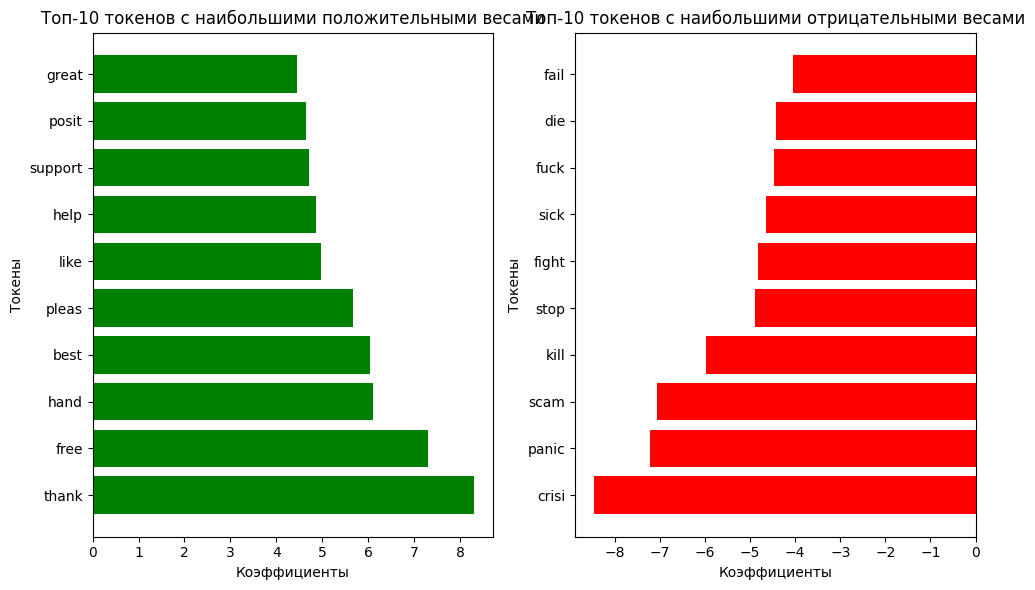

In [69]:
import matplotlib.pyplot as plt
coefficients = lr.coef_[0]
feature_names = cv.get_feature_names_out()
top_positive_indices = coefficients.argsort()[-10:][::-1]
top_negative_indices = coefficients.argsort()[:10]
top_positive_tokens = [feature_names[index] for index in top_positive_indices]
top_positive_coefficients = [coefficients[index] for index in top_positive_indices]
top_negative_tokens = [feature_names[index] for index in top_negative_indices]
top_negative_coefficients = [coefficients[index] for index in top_negative_indices]

plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.barh(top_positive_tokens, top_positive_coefficients, color='green')
plt.xlabel('Коэффициенты')
plt.ylabel('Токены')
plt.title('Топ-10 токенов с наибольшими положительными весами')

plt.subplot(1, 2, 2)
plt.barh(top_negative_tokens, top_negative_coefficients, color='red')
plt.xlabel('Коэффициенты')
plt.ylabel('Токены')
plt.title('Топ-10 токенов с наибольшими отрицательными весами')

plt.tight_layout()
plt.show()


определились достаточно хорошо

## Задание 7 Другие признаки (1.5 балла)

Мы были сконцентрированы на работе с текстами твиттов и не использовали другие признаки - имена пользователя, дату и местоположение

Изучите признаки UserName и ScreenName. полезны ли они? Если полезны, то закодируйте их, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

In [70]:
from scipy.sparse import hstack

user_features = train[['UserName', 'ScreenName']]
user_features_encoded = pd.get_dummies(user_features)

X_train_combined = hstack([X_train_scaled, user_features_encoded])
lr_combined = LogisticRegression(max_iter=1000)
lr_combined.fit(X_train_combined, y_train)

X_test_user_features_encoded = pd.get_dummies(test[['UserName', 'ScreenName']])
X_test_combined = hstack([X_test_scaled, X_test_user_features_encoded])

test_accuracy_combined = accuracy_score(y_test, lr_combined.predict(X_test_combined))
print("Точность модели на тестовой выборке с учетом признаков UserName и ScreenName:", test_accuracy_combined)


Точность модели на тестовой выборке с учетом признаков UserName и ScreenName: 0.5446481961331473


**Ответ:** точность упала((

Изучите признак TweetAt в обучающей выборке: преобразуйте его к типу datetime и нарисуйте его гистограмму с разделением по цвету на оспнове целевой переменной. Полезен ли он? Если полезен, то закодируйте его, добавьте к матрице с отскалированными признаками, обучите логистическую регрессию, замерьте качество.

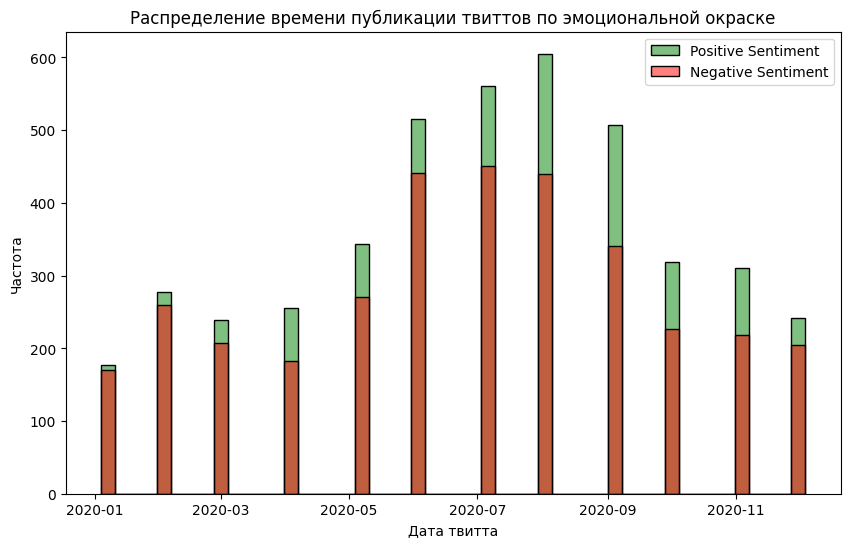

In [74]:
from datetime import datetime
import seaborn as sns

# Преобразуем признак TweetAt к типу datetime с инференцией формата
train['TweetAt'] = pd.to_datetime(train['TweetAt'], errors='coerce')

train = train.dropna(subset=['TweetAt'])

# Создадим два датасета для положительных и отрицательных твиттов
positive_tweets = train[train['Sentiment'] == 1]['TweetAt']
negative_tweets = train[train['Sentiment'] == 0]['TweetAt']

# Построим гистограмму с разделением по цвету
plt.figure(figsize=(10, 6))
sns.histplot(positive_tweets, color='green', alpha=0.5, bins=50, label='Positive Sentiment')
sns.histplot(negative_tweets, color='red', alpha=0.5, bins=50, label='Negative Sentiment')
plt.xlabel('Дата твитта')
plt.ylabel('Частота')
plt.title('Распределение времени публикации твиттов по эмоциональной окраске')
plt.legend()
plt.show()


**Ответ:** как мы видим, положительных всегда чуть больше, но это нам никак не поможет


Поработайте с признаком Location в обучающей выборке. Сколько уникальных значений?

In [75]:
unique_locations = train['Location'].nunique()
print("Количество уникальных значений в столбце Location:", unique_locations)


Количество уникальных значений в столбце Location: 3267


Постройте гистограмму топ-10 по популярности местоположений (исключая Unknown)

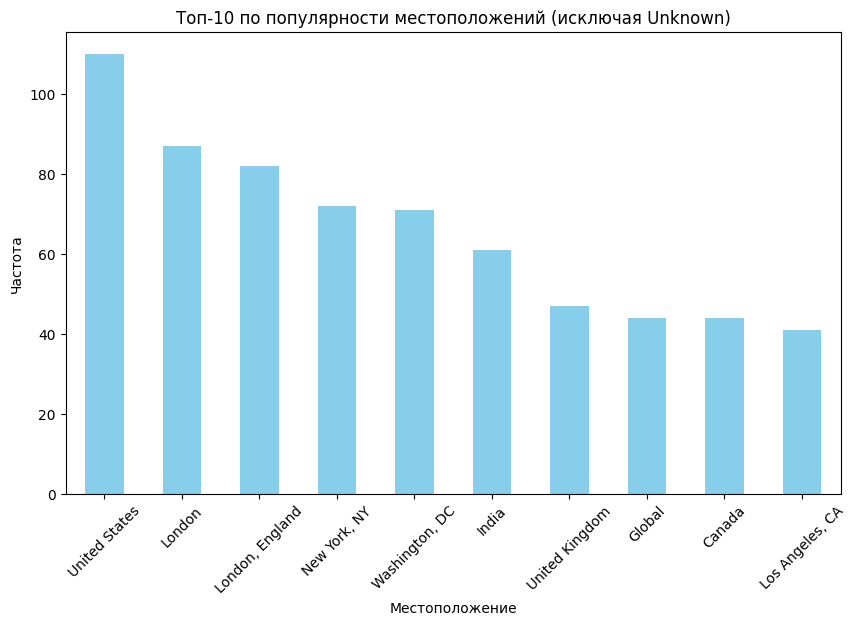

In [76]:
# Исключаем значение "Unknown" и считаем количество вхождений каждого местоположения
top_locations = train[train['Location'] != 'Unknown']['Location'].value_counts().head(10)

# Построим гистограмму топ-10 по популярности местоположений
plt.figure(figsize=(10, 6))
top_locations.plot(kind='bar', color='skyblue')
plt.xlabel('Местоположение')
plt.ylabel('Частота')
plt.title('Топ-10 по популярности местоположений (исключая Unknown)')
plt.xticks(rotation=45)
plt.show()


Видно, что многие местоположения включают в себя более точное название места, чем другие (Например, у некоторых стоит London, UK; а у некоторых просто UK или United Kingdom).

Создайте новый признак WiderLocation, который содержит самое широкое местоположение (например, из London, UK должно получиться UK). Сколько уникальных категорий теперь? Постройте аналогичную гистограмму.

Количество уникальных категорий в новом признаке WiderLocation: 1910


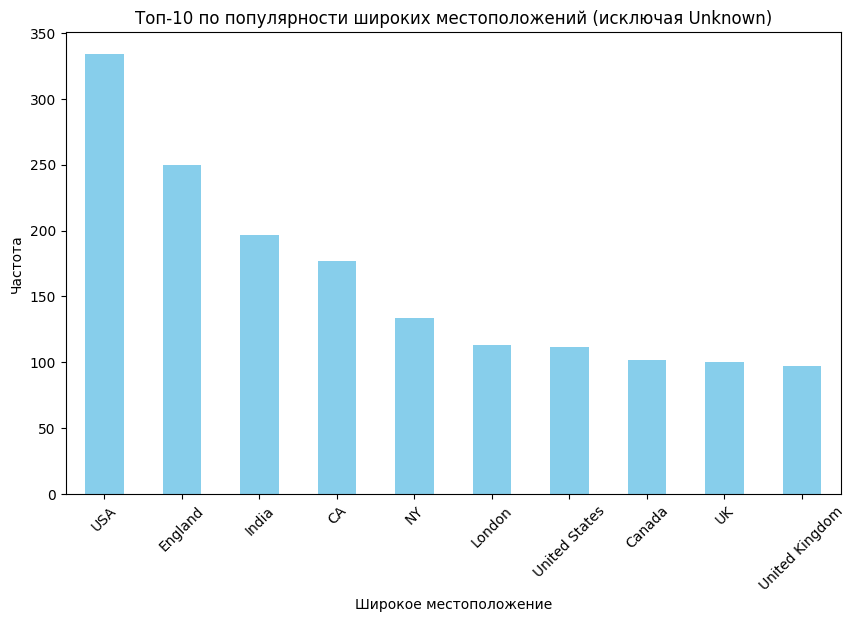

In [77]:
def get_wider_location(location):
    locations = location.split(',')
    return locations[-1].strip()

train['WiderLocation'] = train['Location'].apply(lambda x: get_wider_location(x))
unique_wider_locations = train['WiderLocation'].nunique()
print("Количество уникальных категорий в новом признаке WiderLocation:", unique_wider_locations)

# Построим гистограмму топ-10 по популярности нового признака WiderLocation
top_wider_locations = train[train['WiderLocation'] != 'Unknown']['WiderLocation'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_wider_locations.plot(kind='bar', color='skyblue')
plt.xlabel('Широкое местоположение')
plt.ylabel('Частота')
plt.title('Топ-10 по популярности широких местоположений (исключая Unknown)')
plt.xticks(rotation=45)
plt.show()


Закодируйте признак WiderLocation с помощью OHE таким образом, чтобы создались только столбцы для местоположений, которые встречаются более одного раза. Сколько таких значений?


In [78]:
from sklearn.preprocessing import OneHotEncoder

location_counts = train['WiderLocation'].value_counts()
common_locations = location_counts[location_counts > 1].index.tolist()
filtered_train = train[train['WiderLocation'].isin(common_locations)]

# Применение One-Hot Encoding к отфильтрованным местоположениям
encoder = OneHotEncoder(sparse=False)
encoded_locations = encoder.fit_transform(filtered_train[['WiderLocation']])
unique_filtered_locations = len(common_locations)
print("Количество уникальных значений после фильтрации:", unique_filtered_locations)


Количество уникальных значений после фильтрации: 432


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Добавьте этот признак к матрице отскалированных текстовых признаков, обучите логистическую регрессию, замерьте качество. Как оно изменилось? Оказался ли признак полезным?


*Подсказка:* используйте параметр `categories` в энкодере.

In [90]:
train['WiderLocation'] = train['Location'].apply(lambda x: x.split(',')[-1].strip() if x != 'Unknown' else x)


all_locations = np.unique(np.concatenate([train['WiderLocation'], test['WiderLocation']]))

# Преобразование признака местоположения в разреженную матрицу с учетом всех категорий
encoder = OneHotEncoder(categories=[all_locations], handle_unknown='ignore')
encoded_locations = encoder.fit_transform(train['WiderLocation'].values.reshape(-1, 1))

# Объединение текстовых признаков с закодированным признаком местоположения
X_train_combined = hstack([X_train_scaled, encoded_locations])

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_combined, y_train)
test['WiderLocation'] = test['Location'].apply(lambda x: x.split(',')[-1].strip() if x != 'Unknown' else x)
test_locations = test['WiderLocation'].apply(lambda x: x if x in all_locations else 'Other')
test_encoded_locations = encoder.transform(test_locations.values.reshape(-1, 1))

# Объединение текстовых признаков тестовых данных с закодированным признаком местоположения
X_test_combined = hstack([X_test_scaled, test_encoded_locations])

accuracy_combined = log_reg.score(X_test_combined, y_test)
print("Точность модели после добавления признака местоположения:", accuracy_combined)


KeyError: 'WiderLocation'

**Ответ:** # -- YOUR ANSWER HERE --

## Задание 8 Хорошее качество (Бонус 1 балл)

Добейтесь accuracy=0.9 на тестовой выборке (можно сменить токенайзер, векторайзер, модель и т.д.)

In [91]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Создание модели градиентного бустинга
gb_clf = GradientBoostingClassifier()

# Подбор оптимальных параметров с помощью кросс-валидации
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}
grid_search = GridSearchCV(gb_clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_combined, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

best_model = grid_search.best_estimator_
accuracy_test = best_model.score(X_test_combined, y_test)
print("Точность на тестовой выборке:", accuracy_test)


Лучшие параметры: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 200}
Точность на тестовой выборке: 0.8586804863464221
